In [56]:

import pandas as pd 
import numpy as np 
from utils import * 
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from src.classifier import Classifier
import seaborn as sns 
import matplotlib.pyplot as plt
import glob
import os
import dataframe_image as dfi
import warnings
warnings.simplefilter('ignore')

%load_ext autoreload
%autoreload 2

confusion_matrix_map = {'tp':'true positive', 'fp':'false positive', 'tn':'true negative', 'fn':'false negative'}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
test_results_df = pd.read_csv('../data/results/dataset_test_predict.csv', index_col=0)
test_results_df = test_results_df.merge(pd.read_csv('../data/datasets/dataset_test.csv', index_col=0), left_index=True, right_index=True)
test_results_df = test_results_df[test_results_df.domain != 'Viruses'].copy()

train_results_df = pd.read_csv('../data/results/dataset_train_predict.csv', index_col=0)
train_results_df = train_results_df.merge(pd.read_csv('../data/datasets/dataset_train.csv', index_col=0), left_index=True, right_index=True)
train_results_df = train_results_df[train_results_df.domain != 'Viruses'].copy()

In [58]:
results_df = pd.concat([train_results_df, test_results_df])

In [59]:
def table_1(results_df:pd.DataFrame, path:str=None):

    model_names = [os.path.basename(path).replace('.pkl', '') for path in glob.glob('../models/*pkl')]

    table_df = list()
    for model_name in model_names:
        row = dict()
        row['model_name'] = model_name

        tn, fp, fn, tp = confusion_matrix(results_df['label'], results_df[f'{model_name}_label']).ravel()
        row['true_positive'] = tp
        row['true_negative'] = tn
        row['false_positive'] = fp
        row['false_negative'] = fn
        row['accuracy'] = np.round(balanced_accuracy_score(results_df.label, results_df[f'{model_name}_label']), 4)
        table_df.append(row)

    table_df = pd.DataFrame(table_df).set_index('model_name')
    table_df = table_df.sort_values('false_positive')

    # dfi.export(table_df, path, table_conversion='matplotlib')
    return table_df

table_1(train_results_df)


,true_positive,true_negative,false_positive,false_negative,accuracy
model_name,,,,,
model_v3,273883,20514,1,644,0.9988
model_v1,273157,20513,2,1370,0.9975
model_v2,273794,20513,2,733,0.9986


In [60]:
model_name = 'model_v3'
train_results_df = train_results_df.rename(columns={col:col.replace(model_name, 'model') for col in train_results_df.columns})
test_results_df = test_results_df.rename(columns={col:col.replace(model_name, 'model') for col in test_results_df.columns})
results_df = results_df.rename(columns={col:col.replace(model_name, 'model') for col in results_df.columns})

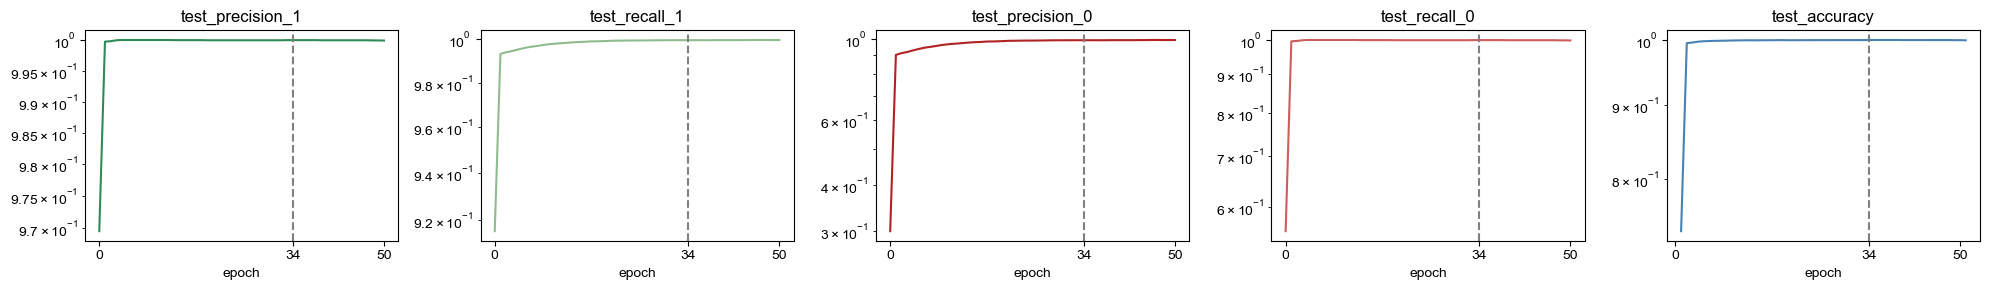

In [68]:
model = Classifier.load('../models/model_v3.pkl')

def figure_1(model:Classifier, path:str=None, metrics:list=['test_precision_1', 'test_recall_1', 'test_precision_0', 'test_recall_0', 'test_accuracy']):
    
    colors = dict()
    colors['test_precision_1'] = 'seagreen'
    colors['test_recall_1'] = 'darkseagreen'
    colors['test_precision_0'] = 'firebrick'
    colors['test_recall_0'] = 'indianred'
    colors['test_accuracy'] = 'steelblue'

    fig, axes = plt.subplots(ncols=len(metrics), figsize=(4 * len(metrics), 3))
    
    for ax, metric in zip(axes, metrics):
        ax.set_title(metric)
        ax = sns.lineplot(x=np.arange(len(model.metrics[metric])), y=model.metrics[metric], label=metric, color=colors[metric], ax=ax, legend=False)
        ax.axvline(x=model.best_epoch, color='gray', linestyle='--')

        xticks = sorted(list(range(0, model.epochs + 1, 50)) + [model.best_epoch])
        ax.set_xticks(xticks, labels=xticks)
        ax.set_xlabel('epoch')
        ax.set_yscale('log')
        
    fig.tight_layout()
    plt.show()

figure_1(model)

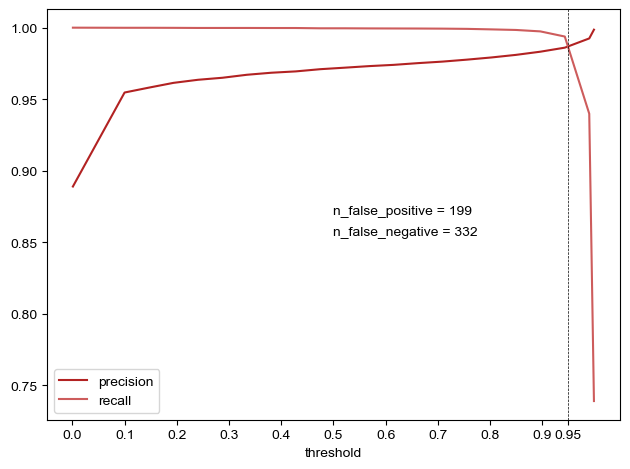

In [69]:
def figure_2(results_df, threshold:float=0.99):

    min_threshold = results_df.model_output_0.min() + 1e-3
    max_threshold = results_df.model_output_0.max() - 1e-3

    thresholds = [min_threshold] + list(np.linspace(0.1, 0.99, 20)) + [max_threshold]
    ax_df = pd.DataFrame(index=np.arange(len(thresholds)))
    ax_df['threshold'] = thresholds
    ax_df['precision'] = [precision(results_df, class_=0, threshold=threshold) for threshold in thresholds]
    ax_df['recall'] = [recall(results_df, class_=0, threshold=threshold) for threshold in thresholds]

    fig, ax = plt.subplots()

    sns.lineplot(data=ax_df, ax=ax, x='threshold', y='precision', label='precision', color='firebrick')
    sns.lineplot(data=ax_df, ax=ax, x='threshold', y='recall', label='recall', color='indianred')
    ax.axvline(threshold, color='black', linewidth=0.5, linestyle='--')

    n_fn = ((results_df.model_output_0 > threshold) & (results_df.label == 1)).sum()
    n_fp = ((results_df.model_output_0 <= threshold) & (results_df.label == 0)).sum()
    ax.text(0.5, 0.5, f'n_false_positive = {n_fp}', transform=ax.transAxes)
    ax.text(0.5, 0.45, f'n_false_negative = {n_fn}', transform=ax.transAxes)

    ax.set_ylabel('')
    x_ticks = sorted(list(np.arange(10) / 10) + [threshold])
    ax.set_xticks(x_ticks, labels=x_ticks)

    fig.tight_layout()
    plt.show()

figure_2(results_df, threshold=0.95)

# False negative is when a sequence is classified spurious, but is real (these are the most concerning)
# False positive is when a sequence is classified real, but is spurious. 

In [ ]:
threshold = 0.95
results_df['model_label'] = np.where(results_df.model_output_0 > threshold, 0, 1)

fp_results_df = results_df[(results_df.model_label == 1) & (results_df.label == 0)].copy()
fn_results_df = results_df[(results_df.model_label == 0) & (results_df.label == 1)].copy()

In [79]:
dataset_df = pd.read_csv('../data/datasets/dataset.csv', index_col=0)
dataset_df.index.duplicated().sum()

np.int64(88422)

In [78]:
fp_results_df[['seq']]

,seq
id,
D3L743,MKDIKLFQLADLAQLVEHRYRKPGVDGSNPSVGKIFVKQRDIKRNKA
A0A2T4Y5G2,MSDATLRSDGAGFYQLVFPEYSLSA
A0A2T4Y5G2,MSDATLRSDGAGFYQLVFPEYSLSA
A0A345CZE1,MEVNQYRRINIWMAILGYSLDVLPVFLS
A0A654CW46,MTGRCRRGRSRVYRAGAYRAGARATRRGRRRVARGYQNPFTISSTH...
...,...
A0A9C7PLX7,MRFSSPSHMLYVLVGPFRRRYFALDRSIFRRRAKCIPTHGLEHVTA...
A0A139DF66,IRAGRNLPDKEFRYLRTVIVTAAVYRGFDQELRLR
A0A0G1UUU8,MNASVAQLAERIHGKDEVAGSIPAAGSIIVDS


In [76]:
# What are the proteins it struggles on?

# def figure(results_df:pd.DataFrame, threshold:float=0.95):

#     results_df = results_df.copy()

#     fig, ax = plt.subplots()

#     # sns.kdeplot(ax=ax, data=results_df[results_df.model_label == 1].seq.apply(len))
#     # sns.kdeplot(ax=ax, data=results_df[results_df.model_label == 0].seq.apply(len))
#     # sns.kdeplot(ax=ax, data=fp_results_df.seq.apply(len))
#     # sns.kdeplot(ax=ax, data=fn_results_df.seq.apply(len))

#     plt.show()

#     return fp_results_df, fn_results_df



In [70]:
fn_results_df.seq.apply(len).mean()
fp_results_df.seq.apply(len).mean()

np.float64(87.08571428571429)

In [71]:
results_df.seq.apply(len).mean()

np.float64(317.21263968478445)

In [66]:
results_df[results_df.label == 0].seq.apply(len).mean()

np.float64(161.2644492475184)

In [75]:
fp_results_df

,model_label,model_output_0,model_output_1,model_v2_label,model_v2_output_0,model_v2_output_1,model_v1_label,model_v1_output_0,model_v1_output_1,antifam_name,...,kegg,file_name,cluster_id,domain,phylum,class,order,family,genus,species
id,,,,,,,,,,,,,,,,,,,,,
A0A9X8JJH0,1,0.935192,0.064808,0,0.935306,0.064694,0,0.962750,0.037250,Translation of predicted DNA regulatory sequence,...,none,none,638,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Pectobacteriaceae,Pectobacterium,Pectobacterium zantedeschiae
A0A0H2Z462,1,0.441077,0.558923,1,0.341151,0.658849,0,0.543270,0.456730,Unclear; Possibly translation of poorly locali...,...,none,none,3235,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,Escherichia coli
A0A0H2Z462,1,0.441077,0.558923,1,0.341151,0.658849,0,0.543270,0.456730,Unclear; Possibly translation of poorly locali...,...,none,none,3235,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,Escherichia coli
A0A7V8AHZ6,1,0.799512,0.200488,0,0.868584,0.131416,0,0.978908,0.021092,tRNA translation,...,none,none,3186,Bacteria,Pseudomonadota,Alphaproteobacteria,Rhodospirillales,Rhodospirillaceae,none,Rhodospirillaceae bacterium
A0A9W4RAB7,1,0.898061,0.101939,0,0.940450,0.059550,0,0.973686,0.026314,tRNA translation,...,none,none,552,Bacteria,Pseudomonadota,Alphaproteobacteria,Hyphomicrobiales,none,none,Hyphomicrobiales bacterium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A0A9C7PLX7,1,0.909727,0.090273,0,0.929092,0.070908,0,0.967581,0.032419,Shadow ORF (opposite leuS),...,none,none,4616,Bacteria,Pseudomonadota,Gammaproteobacteria,none,none,none,Gammaproteobacteria bacterium
A0A139DF66,1,0.910045,0.089955,0,0.958783,0.041217,0,0.978635,0.021365,Antisense to 23S rRNA,...,none,none,4072,Bacteria,Pseudomonadota,Gammaproteobacteria,Pseudomonadales,Marinobacteraceae,Marinobacter,Marinobacter sp. T13-3
A0A0G1UUU8,1,0.933951,0.066049,0,0.878590,0.121410,0,0.946541,0.053459,tRNA translation,...,none,none,5477,Bacteria,Candidatus Joergenseniibacteriota,none,none,none,none,Candidatus Jorgensenbacteria bacterium GW2011_...
